<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Загрузим все необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')
import seaborn as sns 
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from time import time
from tqdm import tqdm

pd.options.display.max_columns = None # полностью отображаем столбцы

In [2]:
try:
    data = pd.read_csv('E:/BuduBogatym/taxi.csv')
except:
    data = pd.read_csv(
        'https://code.s3.yandex.net/datasets/taxi.csv')

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Число значений совпадает - значит нет пропусков

Проверим на наличие дубликатов

In [5]:
print(data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)

0


Переведём в формат даты столбец `datetime` и отсортируем его

In [6]:
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
data.sort_index(inplace=True)

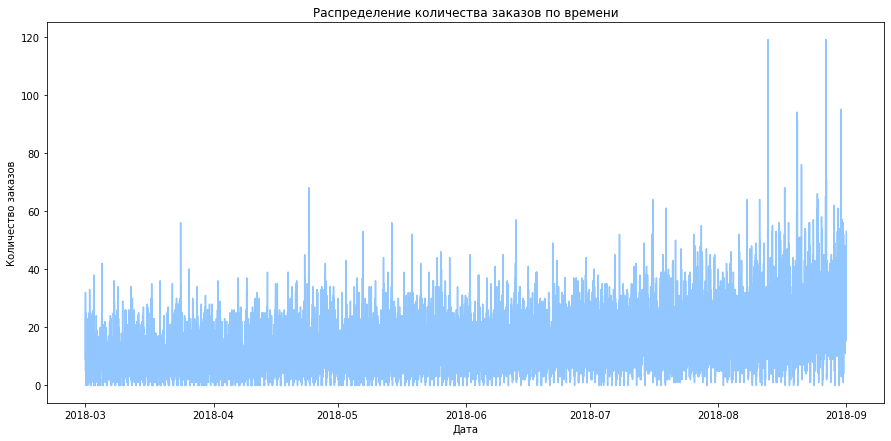

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(data['datetime'], data['num_orders'])
plt.title('Распределение количества заказов по времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Далее ресемплируем датасет по 1 часу

In [8]:
data = data.set_index(['datetime']).resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Оценим временной ряд в более маленьком масштабе

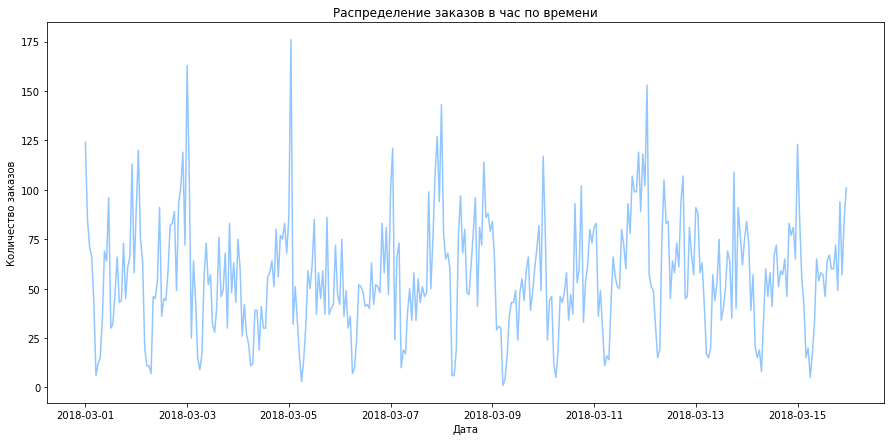

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(data['2018-03-01':'2018-03-15'])
plt.title('Распределение заказов в час по времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Подготовка окончена, можно приступать к анализу

## Анализ

### Скользящее среднее

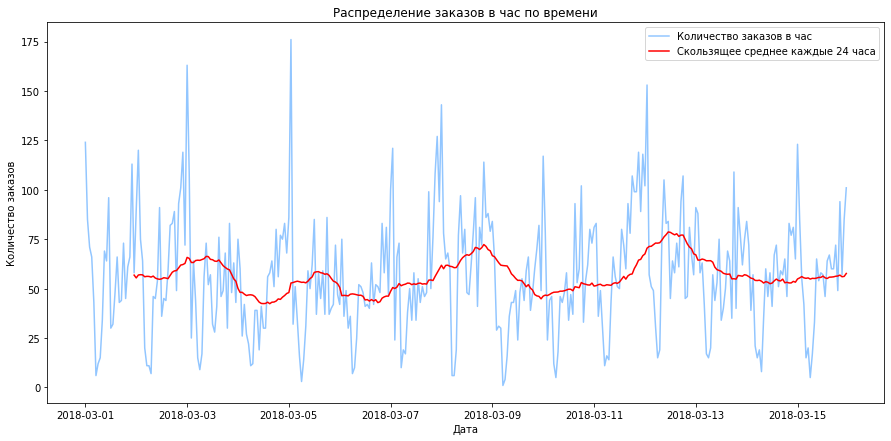

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(data['2018-03-01':'2018-03-15'])
plt.plot(data['2018-03-01':'2018-03-15'].rolling(24).mean(), color='red')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

### Тренды и сезонность

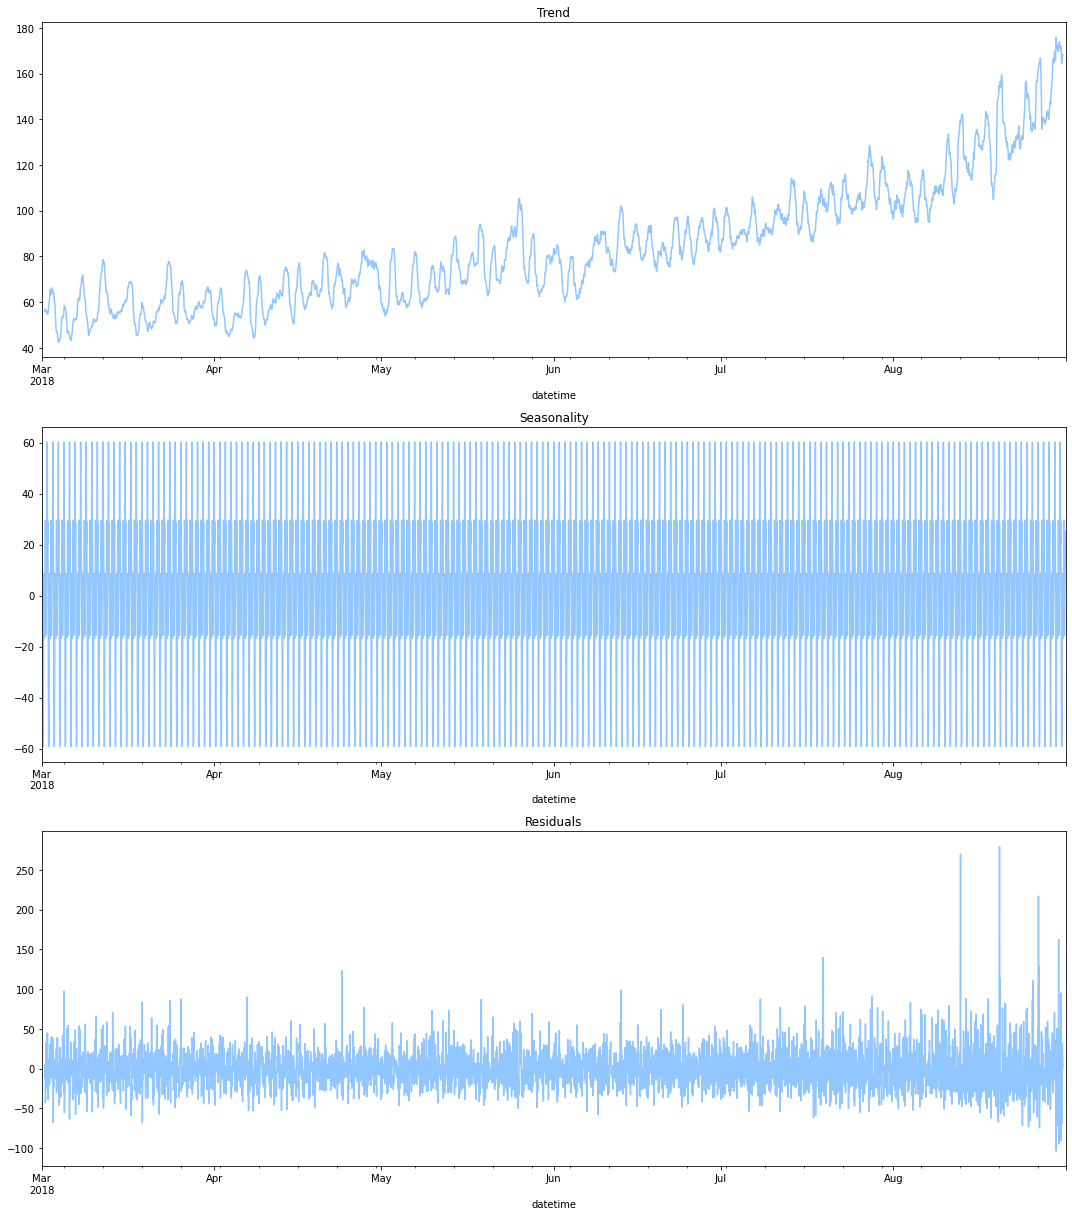

In [16]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 17))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Посмотрим снова графики поближе

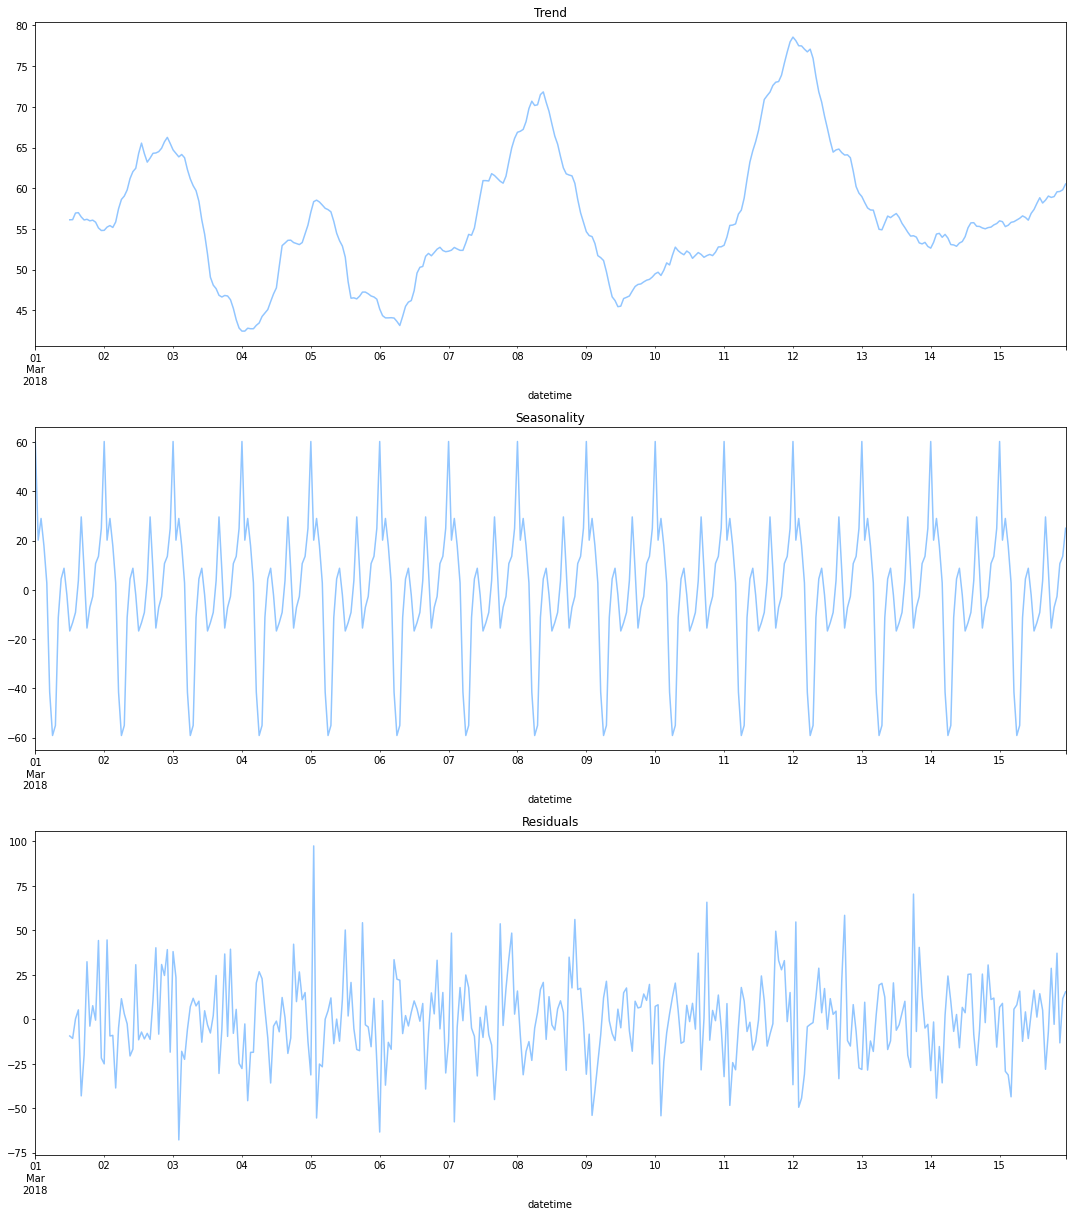

In [17]:
plt.figure(figsize=(15, 17))
plt.subplot(311)
decomposed.trend['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Заказы за день:

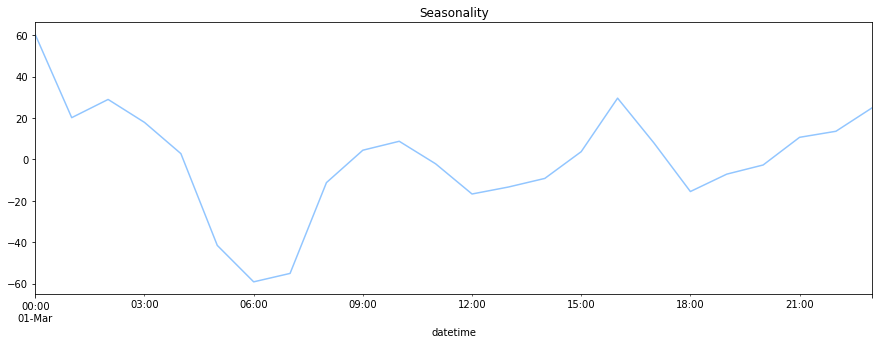

In [22]:
plt.figure(figsize=(15, 17))
plt.subplot(312)
decomposed.seasonal['2018-03-01'].plot(ax=plt.gca())
plt.title('Seasonality');

### Выводы

* Исходя из графика трендов количество заказов растёт с каждым месяцем
* Минимум заказов можно наблюдать с 6 утра, которые постепенно растут ночи
* Исходя из шума - заказов к концу лета куда выше, от чего график разнится

### Стационарный ряд

Найдём скользящее стандартное отклонение — стандартное отклонение по скользящему окну:

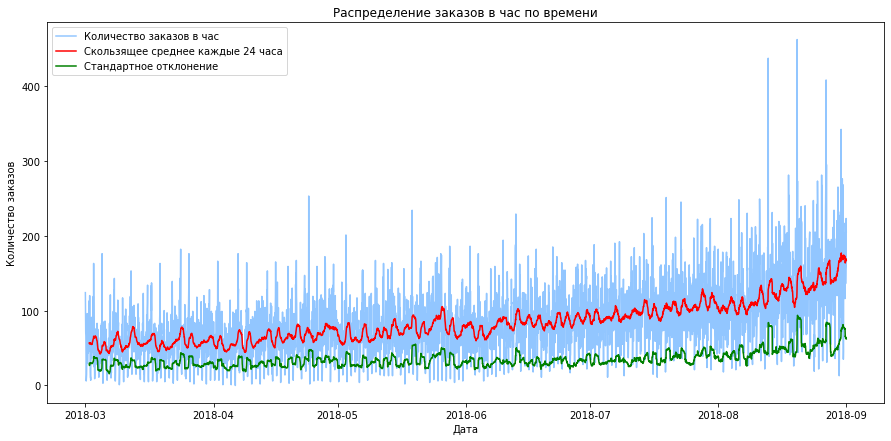

In [25]:
plt.figure(figsize=(15, 7))
plt.plot(data)
plt.plot(data.rolling(24).mean(), color='red')
plt.plot(data.rolling(24).std(), color='green')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Чтобы ряд сделать стационарным, найдём разности его значений. Разности временного ряда — это набор разностей между соседними элементами временного ряда, т. е. из каждого значения вычитается предыдущее.

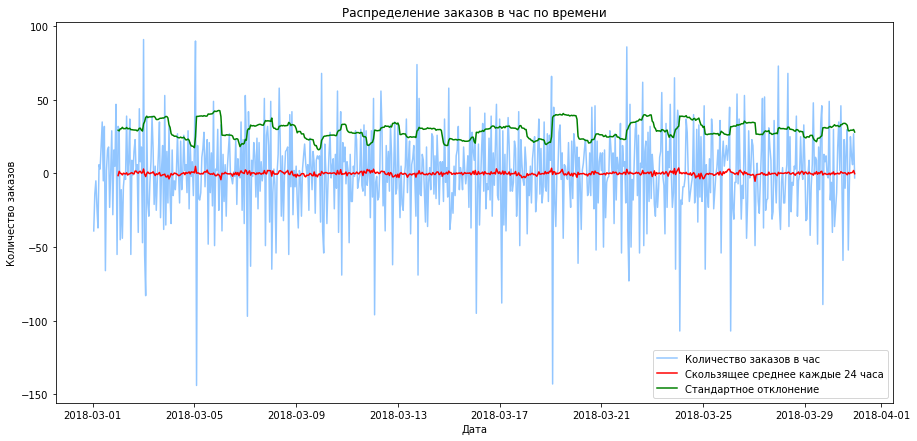

In [26]:
shifted_data = data - data.shift()

plt.figure(figsize=(15, 7))
plt.plot(shifted_data['2018-03-01':'2018-03-30'])
plt.plot(shifted_data['2018-03-01':'2018-03-30'].rolling(24).mean(), color='red')
plt.plot(shifted_data['2018-03-01':'2018-03-30'].rolling(24).std(), color='green')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Удалось привести временной ряд к стационарному виду. Анализ данных окончен, поэтому можно приступать к обучению моделей

## Обучение

Напишем функцию для создания признаков. Разберём каждый тип признаков:

* Календарные признаки - во многих данных тренды и сезонность привязаны к конкретной дате. Тип datetime64 в Pandas уже содержит нужную информацию, осталось лишь представить её как отдельные столбцы.
* Отстающие значения - предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться.
* Скользящее среднее - скользящее среднее как признак задаёт общий тренд временного ряда.
---
Так как у нас идет увеличение числа заказов в течении дня - возьмём максимальное отстающее значение - 24 часа, а скользящее среднее по 6 часов, так как наблюдается, что каждые 6 часов количество заказов как растет, так и падает.

Создадим функцию для создания признаков

In [28]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = data.index.dayofweek
    df['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

Создадим новые фичи, с помощью нашей функции:

In [29]:
make_features(data, 1, 24)

Разделим датасет на train и test, не будем перемешивать данные, так как это уничтожит упорядоченность по датам

In [31]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Создадим функцию для подбора параметров модели

In [33]:
# создаём таблицу для анализа
analisys = pd.DataFrame({'model':[], 'RMSE_model':[], 'RMSE_on_train':[],'time_to_predict':[], 'time_to_fit':[]})
all_models = []

# создаём функцию для подбора параметров
def train_model(model, parameters):
    
    best_rmse = 1000
    best_splits = 0
    best_model = 0
    
    start = time()
    for split in range(6, 25, 2):
        tscv = TimeSeriesSplit(n_splits=split)
        model_random = GridSearchCV(estimator=model,
                                    param_grid=parameters,
                                    scoring='neg_mean_absolute_error',
                                    n_jobs=-1,
                                    cv=tscv, 
                                    verbose=1)
        model_random.fit(train_features, train_target)
        rmse = model_random.best_score_ * -1 ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_splits = split
            best_model = model_random
    
    print('GridSearchCV подбирал сплиты и параметры %.2f секунд' %(time() - start))
    print('Лучшие число сплитов:', best_splits)
    
    time_to_fit = model_random.cv_results_['mean_fit_time'][0]
    print('Время обучения модели %.2f секунд' %time_to_fit)
    
    time_to_predict = model_random.cv_results_['mean_score_time'][0]
    print('Модель предсказывает за %.2f секунд' %time_to_predict)
    
    
    
    model_random = best_model
    
    # высчитаем метрики
    rmse = model_random.best_score_ * -1 ** 0.5
    rmse_on_train = mean_squared_error(train_target, model_random.predict(train_features), squared=False)
    
    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)
    print('RMSE на тренировочной выборке:', rmse_on_train)
    
    predicted = pd.DataFrame(model_random.predict(train_features), index=train_features.index)
    plt.figure(figsize=(15,7))
    plt.plot(train_target[:'2018-03-07'], color='black', alpha=0.7)
    plt.plot(predicted[:'2018-03-07'], color='red', alpha=0.7)
    plt.title('Сравнение предсказаний на трейне модели за первые 7 дней')
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата')
    plt.legend(['Реальные', 'Предсказанные'])
    plt.show()
    
    # заполним все таблицы    
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, rmse_on_train, time_to_predict, time_to_fit])
    analisys.loc[len(analisys.index)] = row
    
    return model_random

### Решающее дерево

Fitting 6 folds for each of 9 candidates, totalling 54 fits
Fitting 8 folds for each of 9 candidates, totalling 72 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 12 folds for each of 9 candidates, totalling 108 fits
Fitting 14 folds for each of 9 candidates, totalling 126 fits
Fitting 16 folds for each of 9 candidates, totalling 144 fits
Fitting 18 folds for each of 9 candidates, totalling 162 fits
Fitting 20 folds for each of 9 candidates, totalling 180 fits
Fitting 22 folds for each of 9 candidates, totalling 198 fits
Fitting 24 folds for each of 9 candidates, totalling 216 fits
GridSearchCV подбирал сплиты и параметры 8.36 секунд
Лучшие число сплитов: 20
Время обучения модели 0.00 секунд
Модель предсказывает за 0.00 секунд
Лучшие параметры: {'max_depth': 7}
RMSE обученной модели: 19.646458533848012
RMSE на тренировочной выборке: 22.66158711034978


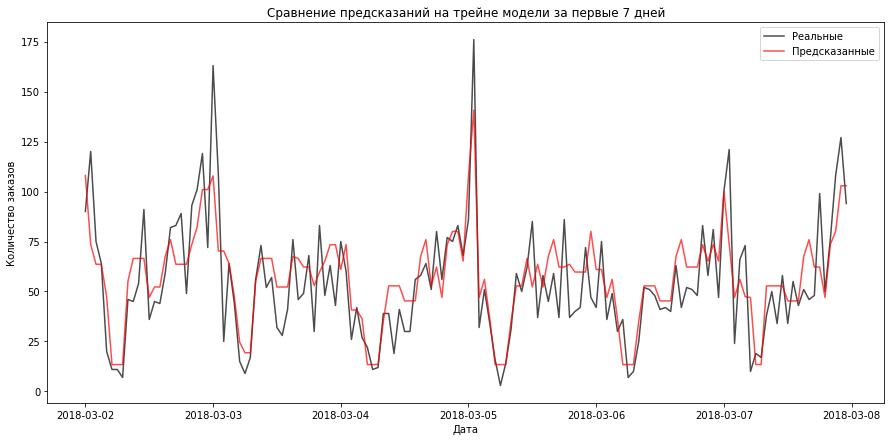

In [34]:

ran_grid_tree = {"max_depth": list(range(3, 12))}

dtr = DecisionTreeRegressor()

dtr_random = train_model(dtr, ran_grid_tree) 

### Случайный лес

Fitting 6 folds for each of 28 candidates, totalling 168 fits
Fitting 8 folds for each of 28 candidates, totalling 224 fits
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Fitting 12 folds for each of 28 candidates, totalling 336 fits
Fitting 14 folds for each of 28 candidates, totalling 392 fits
Fitting 16 folds for each of 28 candidates, totalling 448 fits
Fitting 18 folds for each of 28 candidates, totalling 504 fits
Fitting 20 folds for each of 28 candidates, totalling 560 fits
Fitting 22 folds for each of 28 candidates, totalling 616 fits
Fitting 24 folds for each of 28 candidates, totalling 672 fits
GridSearchCV подбирал сплиты и параметры 197.15 секунд
Лучшие число сплитов: 22
Время обучения модели 0.11 секунд
Модель предсказывает за 0.03 секунд
Лучшие параметры: {'max_depth': 8, 'n_estimators': 300}
RMSE обученной модели: 17.77947519200359
RMSE на тренировочной выборке: 19.616819777681492


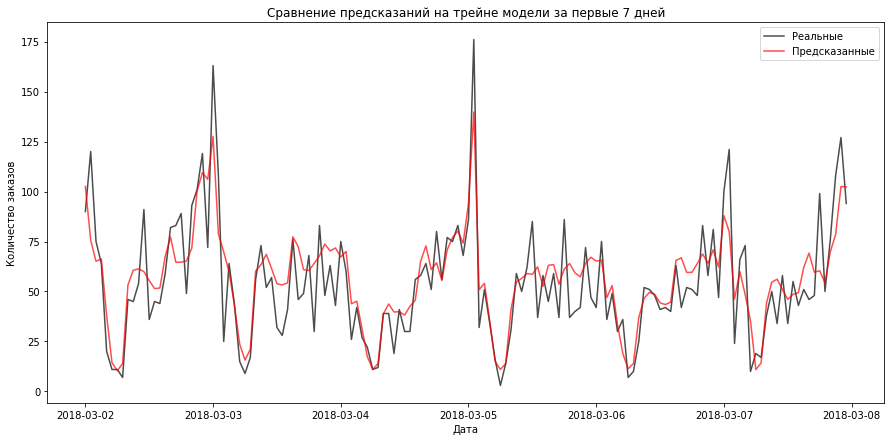

In [35]:
ran_grid_forest = {
    'max_depth': list(range(2, 9)),
    'n_estimators': [50, 100, 200, 300]
}

rfr = RandomForestRegressor(n_jobs=-1)

rfr_random = train_model(rfr, ran_grid_forest)

### LightGBM

Fitting 6 folds for each of 15 candidates, totalling 90 fits
Fitting 8 folds for each of 15 candidates, totalling 120 fits
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Fitting 12 folds for each of 15 candidates, totalling 180 fits
Fitting 14 folds for each of 15 candidates, totalling 210 fits
Fitting 16 folds for each of 15 candidates, totalling 240 fits
Fitting 18 folds for each of 15 candidates, totalling 270 fits
Fitting 20 folds for each of 15 candidates, totalling 300 fits
Fitting 22 folds for each of 15 candidates, totalling 330 fits
Fitting 24 folds for each of 15 candidates, totalling 360 fits
GridSearchCV подбирал сплиты и параметры 14.03 секунд
Лучшие число сплитов: 24
Время обучения модели 0.05 секунд
Модель предсказывает за 0.00 секунд
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10}
RMSE обученной модели: 17.283307315435934
RMSE на тренировочной выборке: 17.36408682552842


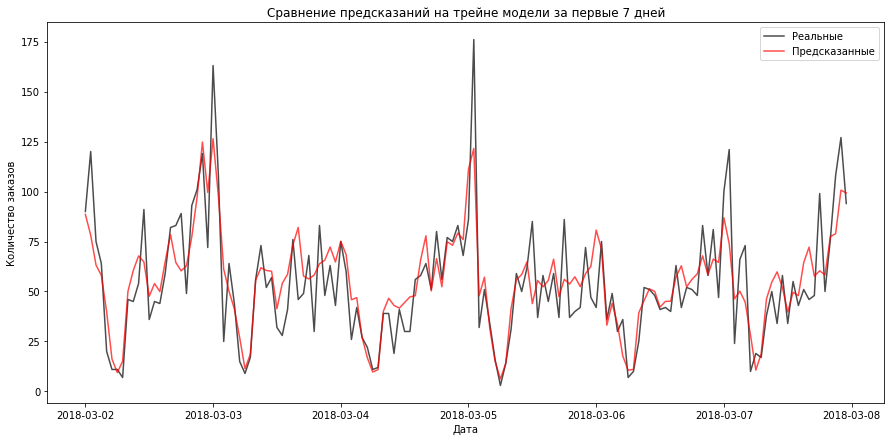

In [36]:
rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE')

gbm_random = train_model(gbm, rand_lgbm_param)

### XGboost

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Fitting 8 folds for each of 24 candidates, totalling 192 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 12 folds for each of 24 candidates, totalling 288 fits
Fitting 14 folds for each of 24 candidates, totalling 336 fits
Fitting 16 folds for each of 24 candidates, totalling 384 fits
Fitting 18 folds for each of 24 candidates, totalling 432 fits
Fitting 20 folds for each of 24 candidates, totalling 480 fits
Fitting 22 folds for each of 24 candidates, totalling 528 fits
Fitting 24 folds for each of 24 candidates, totalling 576 fits
GridSearchCV подбирал сплиты и параметры 43.16 секунд
Лучшие число сплитов: 22
Время обучения модели 0.04 секунд
Модель предсказывает за 0.00 секунд
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5}
RMSE обученной модели: 17.59106375688191
RMSE на тренировочной выборке: 17.5753648997937


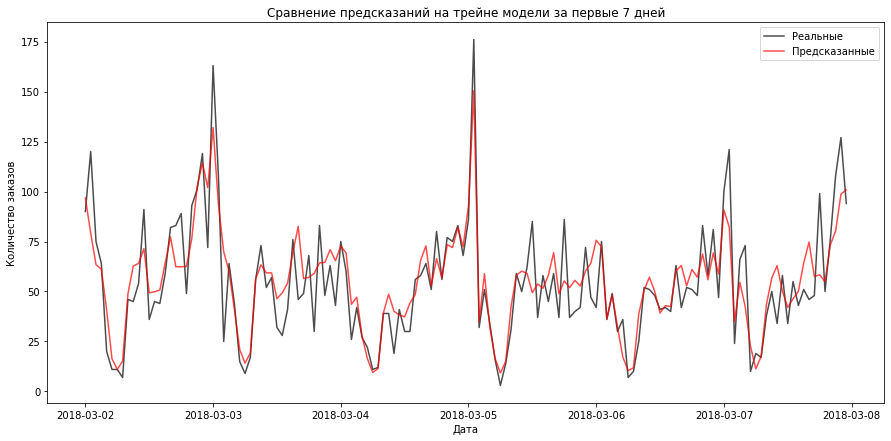

In [37]:
rand_xgb_param = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'learning_rate': [0.1, 0.15, 0.3]
}

xb = xgb.XGBRegressor(booster='gbtree', 
                      eval_metric='rmse', 
                      use_rmm=True,
                     verbosity=0)

xb_random = train_model(xb, rand_xgb_param)

### Catboost

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Fitting 8 folds for each of 10 candidates, totalling 80 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 12 folds for each of 10 candidates, totalling 120 fits
Fitting 14 folds for each of 10 candidates, totalling 140 fits
Fitting 16 folds for each of 10 candidates, totalling 160 fits
Fitting 18 folds for each of 10 candidates, totalling 180 fits
Fitting 20 folds for each of 10 candidates, totalling 200 fits
Fitting 22 folds for each of 10 candidates, totalling 220 fits
Fitting 24 folds for each of 10 candidates, totalling 240 fits
GridSearchCV подбирал сплиты и параметры 173.02 секунд
Лучшие число сплитов: 24
Время обучения модели 0.74 секунд
Модель предсказывает за 0.00 секунд
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3}
RMSE обученной модели: 17.55152968273592
RMSE на тренировочной выборке: 18.15708801561901


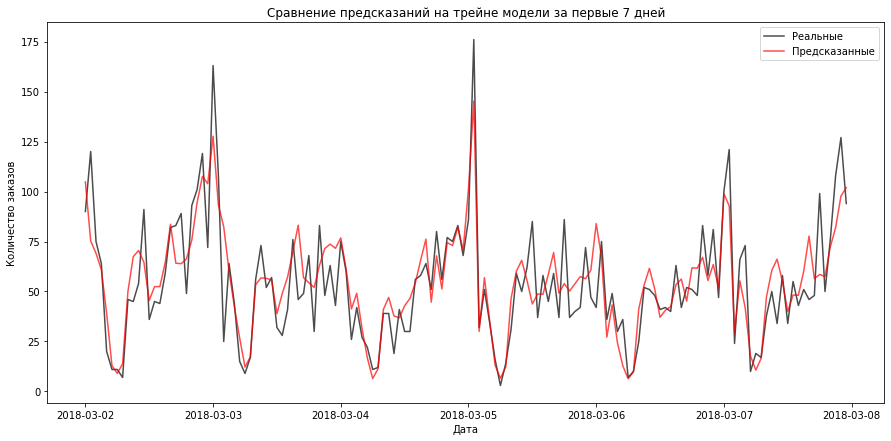

In [42]:
rand_cat_param = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.1, 0.2]
}

cat = CatBoostRegressor(verbose=False) 
 

cat_random = train_model(cat, rand_cat_param)

,model,RMSE_model,RMSE_on_train,time_to_predict,time_to_fit,names
0,DecisionTreeRegressor(),19.646459,22.661587,0.001084,0.002669,DecisionTree
1,RandomForestRegressor(n_jobs=-1),17.779475,19.616820,0.031737,0.112644,RandomForest
2,"LGBMRegressor(metric='RMSE', objective='regres...",17.283307,17.364087,0.002127,0.048669,LightGBM
3,"XGBRegressor(base_score=None, booster='gbtree'...",17.591064,17.575365,0.003336,0.043581,XGBoost
4,<catboost.core.CatBoostRegressor object at 0x0...,17.551530,18.157088,0.002002,0.656088,CatBoost


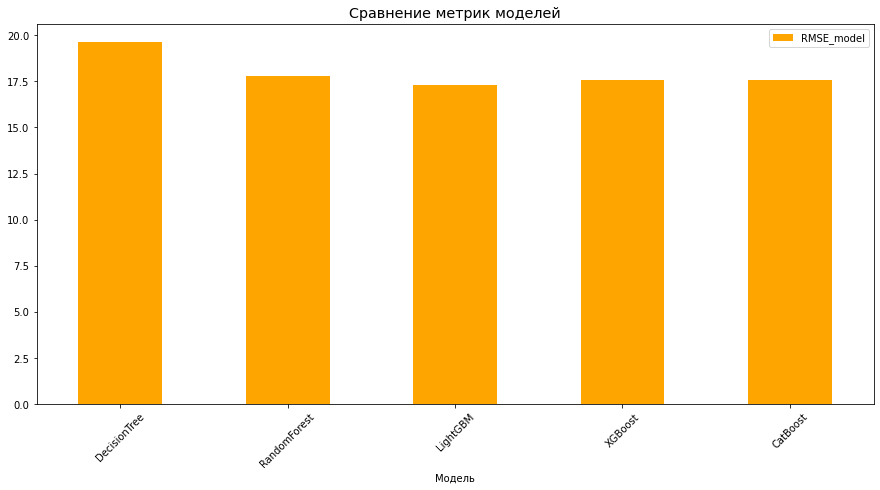

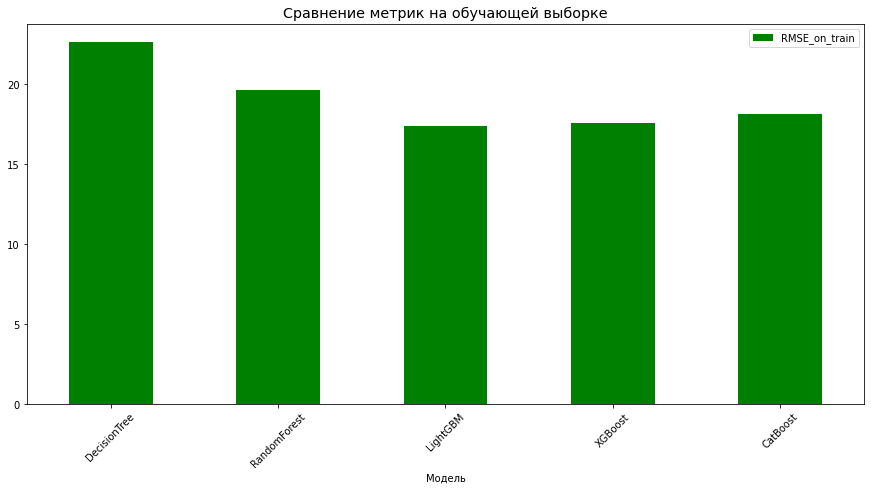

In [43]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='RMSE_model', x='names', rot=45, figsize=(15,7), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='RMSE_on_train', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение метрик на обучающей выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

### Вывод

Исходя из полученных моделей, лучше всего себя показала на рандомной модели - LightGBM с параметрами max_depth: 10 и learning_rate: 0.1 c количеством выборок для обучения TimeSeriesSplit - 24, потому для тестовой выборки будем использовать LightGBM.

Теперь можно перейти к тестированию

## Тестирование

In [46]:
predicted = gbm_random.predict(test_features)
rmse_on_test = mean_squared_error(test_target, predicted, squared=False)
print('RMSE на тестовой выборке при использовании GridSearchCV:', rmse_on_test)

RMSE на тестовой выборке при использовании GridSearchCV: 43.506108154224414


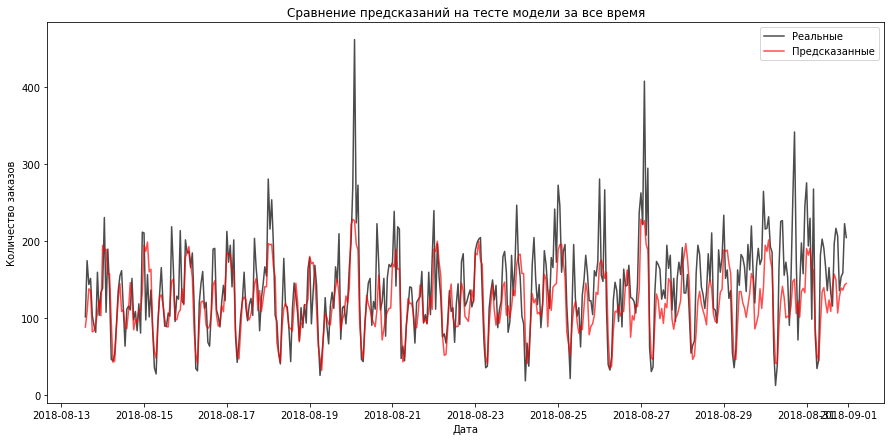

In [47]:
predicted = pd.DataFrame(predicted, index=test_features.index)

plt.figure(figsize=(15,7))
plt.plot(test_target, color='black', alpha=0.7)
plt.plot(predicted, color='red', alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели за все время')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

### Вывод

RMSE модели 43.5, но все же по графикам видно, что модель ошибается сильнее, где тренд увеличения заказов стал выше. Данных слишком мало, чтобы точно предсказывать, что тренд заказов увеличится. И так же плохо предсказывает резкие выбросы значений - где заказов было значительно больше.